# Assignment 1

*Part of the course:
Machine Learning (code: INFOB3ML), fall 2023, Utrecht University*

Total points: 10

Deadline: Friday 15 September, 23:59

**Write your names and student numbers here: ___**

Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**

## Linear Regression with Regularisation
In this assignment, you will perform several simulation experiments with linear regression, in order to investigate the effects of regularisation.

## Overview
### Data generation
Every datapoint $(x,t)$ will be sampled randomly, with both $x$ and $t$ in $\mathbb{R}$. (Note that the book from Introduction to Machine Learning called the output $y$, while this course's book calls it $t$.) The input $x$ is uniformly distributed between $-1$ and $1$.

Once we have our input $x$, we generate our output $t$ according to $t = 1 - \cos(x) + \epsilon$, where $\epsilon$ is normally distributed with expected value = 0 and variance = $\sigma^2$.
All the random numbers should be generated **independently** from one another.

### Regression

We'll implement *regularised* regression, adding a penalty $\lambda \mathbf{w}^T \mathbf{w}$ to our training loss. Linear regression with this form of regularisation penalty is also called *ridge regression*. We are going to try out different values of $\lambda$.

We'll use regression with order five polynomials like in the book. This means that for each weight vector $\mathbf{w}$, our hypothesis is of the form
$$f(x; \mathbf{w}) = \sum_{i=0}^5 w_i x^i.$$

## Your Code

To make it clear what your code is supposed to do and how it should be formatted, we provide you general schema for each to-be-written function. Some functions come with additional hints about useful in-built functions or procedural details. You might write the function's body differently than the hints suggests. That's totally fine as long as the function works as it supposed to work.

Use numpy arrays for functionalities involving vectors and matrices. [Here is an overview of numpy, which includes many functions you'll find useful in this course, as well as some more advanced ones.](https://numpy.org/doc/stable/user/quickstart.html)

Some specific notes about numpy:

* Make sure to use numpy arrays (`np.ndarray`), not `np.matrix`! Arrays are the standard choice, and they can represent vectors, matrices, as well as more general objects. Some of the pre-written code below won't work if you use `np.matrix`.

* To multiply two matrices, write `A @ B`. It is a shorthand for the function [`matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html).

* To generate random numbers, use for instance [`rg.uniform`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.uniform.html#numpy.random.Generator.uniform) and [`rg.normal`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal). (The `rg` here is a random number generator object, created in the TEST block below.)

### Data generation with noise

**Task 1** (1 point)

Write a function `generate_data` you can use to generate a dataset and outputs the pair of vectors `(x,t)`, accepting parameters $N$ and $\sigma^2$. Be sure to check if your normal-distribution-generator needs $\sigma$ (standard deviation) or $\sigma^2$ (variance) as input parameter. Both `x` and `t` should be 1-dimensional numpy arrays, i.e. their shape should be `(N,)`.

In [75]:
import numpy as np
import math

# Some functions you may find useful (here and later):
# np.cos, np.ones, np.linalg.inv, np.hstack, np.matmul (or @), np.eye, math.sqrt.

def generate_data(N, sigma_squared):
    # Your code here
    x = rg.uniform(-1, 1, N)
    t = np.ndarray((N,))
    for i in range(N):
        eps_i = rg.normal(0, np.sqrt(sigma_squared))
        t[i] = 1 - np.cos(x[i])+eps_i
    return x,t
    pass




In [76]:
# ██████████ TEST ██████████
# (These "TEST" blocks can help you quickly check if there's something
# obviously wrong with the code you wrote.)
# Setting a seed with the optional argument to default_rng below helps to
# make the data generation deterministic for comparison reasons.
rg = np.random.default_rng(seed = 1)
toy_xs, toy_t = generate_data(3, 0.1)
# Check if the shapes of the output arrays are as specified above:
print(toy_xs.shape)
print(toy_xs)
print(toy_t.shape)
print(toy_t)

(3,)
[ 0.02364325  0.90092739 -0.71168077]
(3,)
[-0.41181501  0.66541541  0.38389081]


Next, in order to learn 5th-order polynomials, we want to have a function that computes the matrix $\mathbf{X}$. (See equation (1.18) on page 28 of the book for what this matrix should look like.)

**Question 2** (1 point)

(a) When dealing with $N$ data points, what should the size of the $\mathbf{X}$-matrix be? (Give the number or rows and the number of columns.)

(b) Where in the matrix will you find the vector `x_scalars`?

(c) Where in the matrix will you find $\mathbf{x}_1$ (the feature vector associated to the first data point)?

(a) = The size would be N times 6(Heighth is N, width is 6)

(b) = The second column of the matrix

(C) = The first row of the matrix


**Task 3** (1 point)

Write a function `compute_X_matrix` that takes a numpy array `x_scalars` as produced by your code above, and returns the matrix `X` needed by linear regression with 5th-order polynomials.

In [77]:
def compute_X_matrix(x_scalars):
    # Your code here
    X = np.ndarray(shape =(len(x_scalars),6))
    for j in range(len(x_scalars)):
        X[j,0] = 1
        X[j,1] = x_scalars[j]
        X[j,2] = x_scalars[j]**2
        X[j,3] = x_scalars[j]**3
        X[j,4] = x_scalars[j]**4
        X[j,5] = x_scalars[j]**5
    return X

In [78]:
# ██████████ TEST ██████████
toy_X = compute_X_matrix(toy_xs)
print(toy_xs)
print(toy_X)

[ 0.02364325  0.90092739 -0.71168077]
[[ 1.00000000e+00  2.36432494e-02  5.59003242e-04  1.32166531e-05
   3.12484625e-07  7.38815192e-09]
 [ 1.00000000e+00  9.00927393e-01  8.11670167e-01  7.31255887e-01
   6.58808460e-01  5.93538588e-01]
 [ 1.00000000e+00 -7.11680775e-01  5.06489525e-01 -3.60458857e-01
   2.56531639e-01 -1.82568635e-01]]


### Fitting linear regression

The function provided below will plot the target function $1 - \cos(x)$, a regression function, and the training data all in one plot. It will be helpful in testing your code for the task below.

In [79]:
import matplotlib.pyplot as plt

def plot_regression_result(xs_train, t_train, w, include_target_function=True):
    xs_plot = np.linspace(-2, 2, 101)
    X_plot = compute_X_matrix(xs_plot)
    if include_target_function:
        plt.plot(xs_plot, 1 - np.cos(xs_plot), c='black') # target 
    plt.scatter(xs_train, t_train, c='blue', marker=".")
    plt.plot(xs_plot, X_plot @ w, c='red')
    plt.ylim(-1, 1.5)
    plt.show()

**Task 4** (1 point)

Write code that fits a regularised linear regression hypothesis to training data, in other words, a function that computes our $\hat{\mathbf{w}}$. Use numpy to carry out the necessary matrix operations to find an analytic solution; don't use linear regression functionality from Python packages for machine learning. In other words, compute $\hat{\mathbf{w}}$ according to the equation (1.21) on page 36 of the book. Give your function a parameter `lamb` which tells it the value of $\lambda$.
   

In [80]:
def fit_ridge(X, t, lamb):
    # Your code here w = (XTX + NλI)−1XTt
    XT = X.transpose()
    XTX = XT @ X
    N = X.shape[1]
    I = np.identity(N)
    NLI = N*lamb*I
    Sum = XTX + NLI
    Sum_invert = np.linalg.inv(Sum)
    w_hat = (Sum_invert @XT) @ t
    return w_hat
    pass

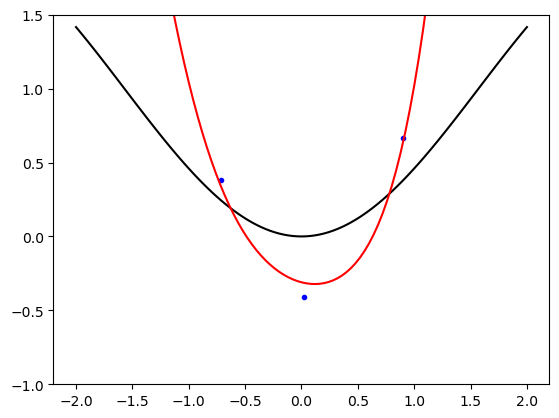

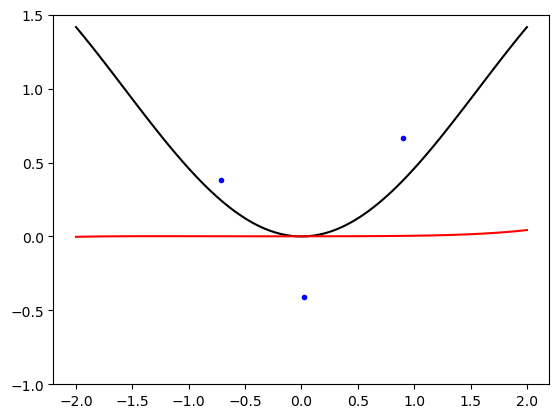

In [81]:
# ██████████ TEST ██████████
plot_regression_result(toy_xs, toy_t, fit_ridge(toy_X, toy_t, 0.01))
plot_regression_result(toy_xs, toy_t, fit_ridge(toy_X, toy_t, 100))

### Squared loss over the data

The following code (which you don't need to change) evaluates a learned linear regression function $\hat{\mathbf{w}}$ with respect to the data $\mathbf{X}, \mathbf{t}$ using the squared error loss. This Python function can be used to compute training, validation or test loss for $\hat{\mathbf{w}}$, depending of the kind of data passed to it.

In [82]:
def compute_loss(w, X, t):
    N, k = X.shape
    t_hat = X @ w
    t_error = t_hat - t
    sum_of_squared_errors = t_error.T @ t_error
    loss = sum_of_squared_errors / N
    return loss

## The effect of $\lambda$

Now it's time to do some experiments and look at the results.

**Task 5** (1 point)

Generate a dataset of $N=15$ data points with noise level $\sigma^2 = 0.1$. (You'll use this dataset in tasks/questions 5 through 7.) For the values of $\lambda$ provided in the code below, fit a regularised regression curve to the data and compute the loss. Display the results in a plot.

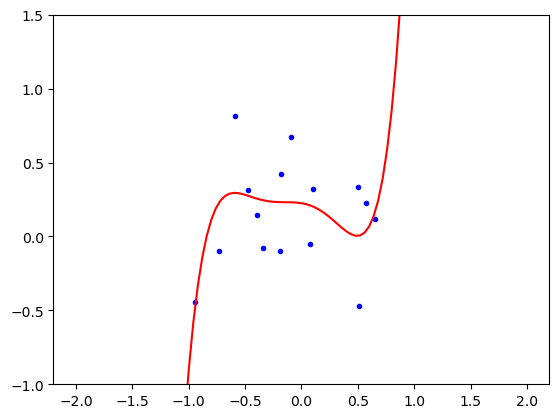

lambda = 1e-05
w_hat = [ 0.22482677 -0.12416459 -0.79756074 -1.59516968  1.87561868  3.92396607]


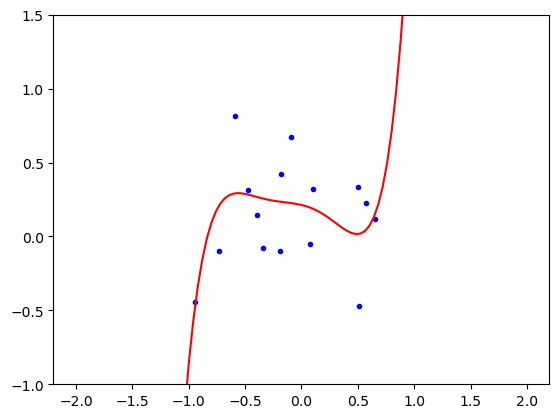

lambda = 0.0001
w_hat = [ 0.21297374 -0.18142254 -0.58892807 -1.16418397  1.37883457  3.21010898]


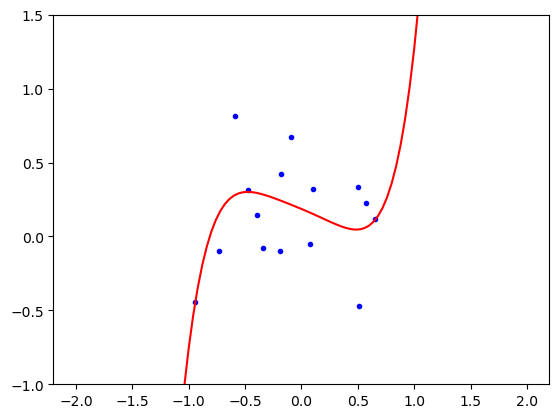

lambda = 0.001
w_hat = [ 0.18573238 -0.32017279 -0.0889946  -0.09186171  0.16181915  1.42399619]


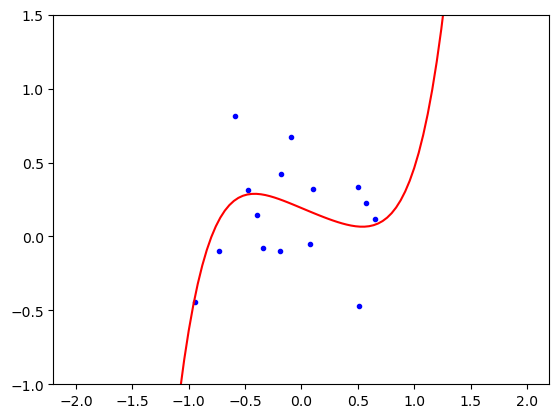

lambda = 0.01
w_hat = [ 0.19212063 -0.32009253 -0.00617384  0.28266944 -0.27259836  0.58673559]


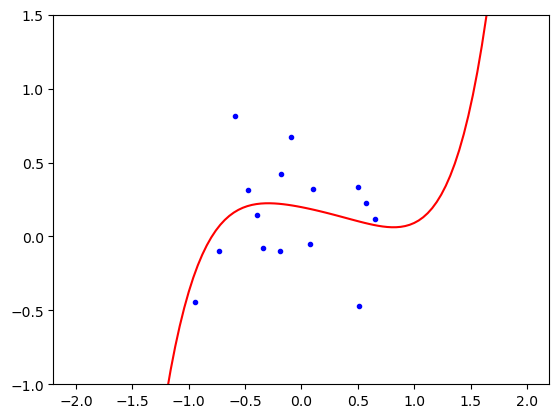

lambda = 0.1
w_hat = [ 0.1981034  -0.14954754 -0.13459906  0.15504685 -0.20527803  0.2274745 ]


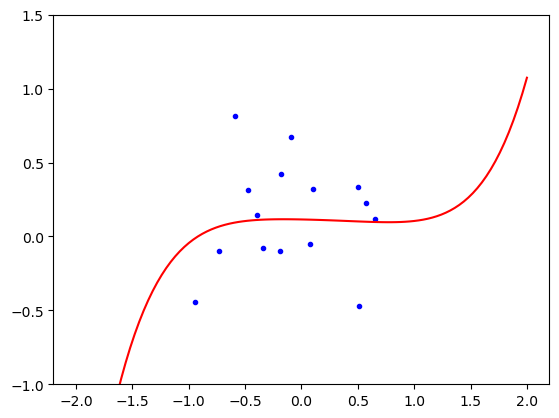

lambda = 1.0
w_hat = [ 0.11489449 -0.01582167 -0.03574549  0.04058104 -0.04927272  0.04990904]


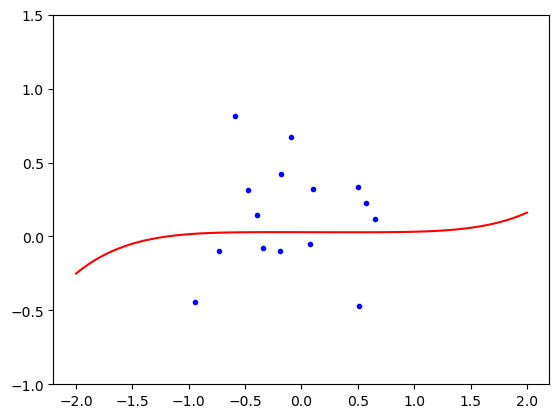

lambda = 10.0
w_hat = [ 0.02880056 -0.00164962 -0.00096643  0.00456425 -0.00438469  0.00540013]


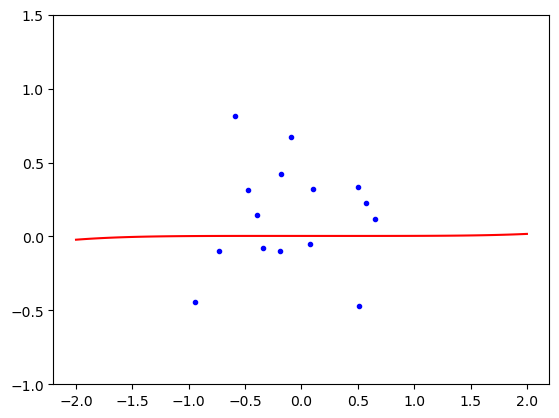

lambda = 100.0
w_hat = [ 3.48584788e-03 -2.10663533e-04  3.75980724e-05  4.32902317e-04
 -3.81064447e-04  5.18717879e-04]


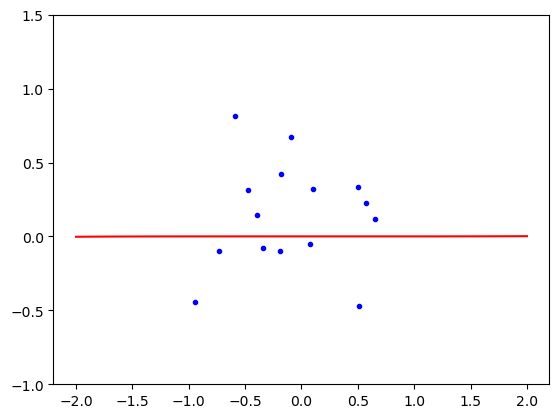

lambda = 1000.0
w_hat = [ 3.56252683e-04 -2.17422963e-05  5.52623168e-06  4.29168022e-05
 -3.73181927e-05  5.15410886e-05]


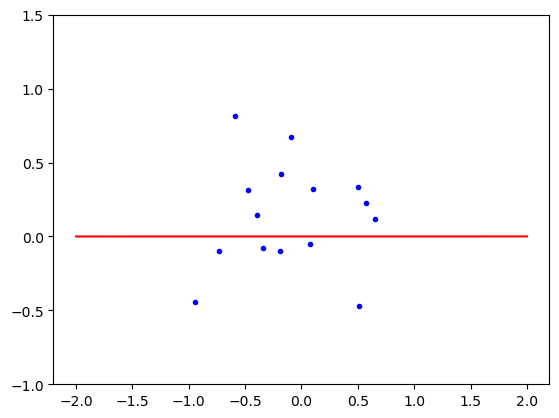

lambda = 10000.0
w_hat = [ 3.57040004e-05 -2.18127794e-06  5.70831755e-07  4.28776393e-06
 -3.72366002e-06  5.15064759e-06]


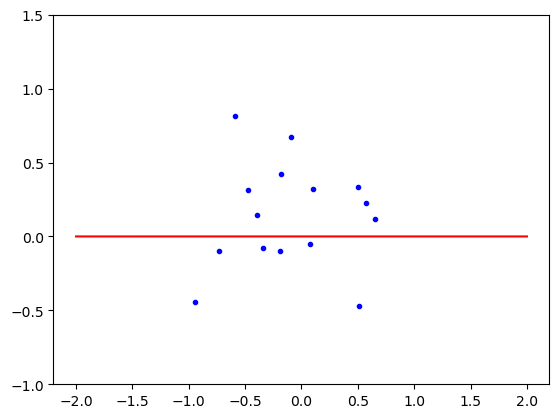

lambda = 100000.0
w_hat = [ 3.57118947e-06 -2.18198575e-07  5.72658211e-08  4.28737043e-07
 -3.72284124e-07  5.15029988e-07]


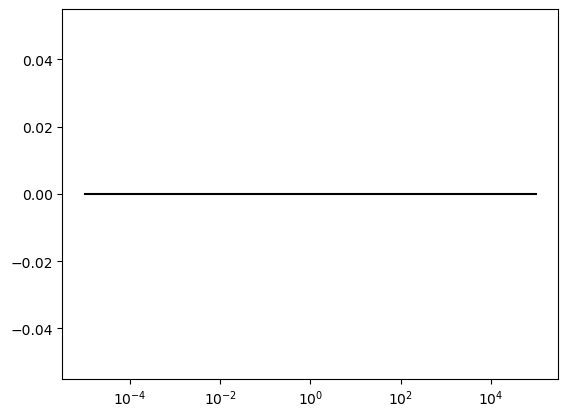

[ 0.65540519 -0.18160173  0.09918738 -0.94488177  0.50702622  0.07628663
 -0.34053657  0.57685741 -0.39361034 -0.09300422 -0.73191661 -0.19377403
 -0.59308952 -0.47537332  0.50072935]
[ 0.12004567  0.42566323  0.32326922 -0.44318355 -0.47155082 -0.05235937
 -0.07608392  0.22937911  0.1451928   0.67404119 -0.09554675 -0.10069367
  0.81676327  0.31538352  0.33244639]


In [83]:
# rg = np.random.default_rng(seed = 1)

lambdas = 10 ** np.linspace(-5, 5, 11)
losses = np.zeros_like(lambdas)

data, t = generate_data(15, 0.1)
X = compute_X_matrix(data)
for lamb in lambdas:
    plot_regression_result(data, t, fit_ridge(X, t, lamb), include_target_function=False)
    w_hat = fit_ridge(X, t, lamb)
    #loss = compute_loss(w, X, t)
    print("lambda =",lamb)
    print("w_hat =", w_hat)
    #print("loss =", loss)
plt.semilogx(lambdas, losses, c='black') # target 
plt.show()

print(data)
print(t)

**Question 6** (1 point) Your plot should show that as $\lambda$ gets larger, the loss also gets larger. Explain why this is to be expected.

L′ = L + λw^Tw
when lambda increases, the penalty becomes more signifcant in the loss function. The line gets smoother, and 

**Task/Question 7** (1 point)

Using the same data, answer the following questions:

For what values of $\lambda > 0$ do you clearly see overfitting? For what values of $\lambda$ do you see underfitting? To support your answer, include plots for some values of $\lambda$, and point out what features of those plots tell you that over-/underfitting is going on.

In [84]:
# Your code here
print("We can clearly see overfitting in plots with lambda values below $\lamda$ ")

We can clearly see overfitting in plots with lambda values below $\lamda$ 


We can clearly see overfitting in plots with lambda values below $\lambda$ = 0.01, and we can clearly see underfitting with lambda values larger than $\lambda$ = 1 

## Cross-validation

To find a good value of $\lambda$, a variety of techniques exist. One that obviously does *not* work is to look at the training loss as a function of $\lambda$ (like you plotted above): that would always suggest to make $\lambda$ as small as possible! A versatile technique that you've already seen in an earlier course (or in section 1.5 of the book) is **cross-validation**.

**Task 8** (1 point)

Write some code to do the following: sample a new dataset of $N = 50$ data points and $\sigma^2=0.1$. (You'll use this dataset for all the remaining tasks and questions.) Write a function that, given data and value of $\lambda$, computes the leave-one-out cross-validation (LOOCV) loss, as explained in section 1.5.2 of the book. Then make a plot similar to what we did in task 5 for the training loss, but this time displaying the LOOCV loss as a function of $\lambda$.

Note that the third argument, `fitting_function`, should be the name of a function that `LOOCV` can call to compute `w`. If `fit_ridge` is passed, your previously written function will be used. But later, you'll call it with a different fitting function.

In [74]:
def LOOCV(X, t, fitting_function, lamb):
    N, k  = X.shape
    sum_of_losses = 0.0
    for leave_out in range(N):
        X_lo = np.delete(X, leave_out, axis = 0)  # Leave one data point out
        t_lo = np.delete(t, leave_out)
        print(X_lo)
        print(t_lo)
        print(fitting_function(X_lo, t_lo, lamb))
        sum_of_losses = compute_loss(fitting_function(X_lo, t_lo, lamb), X[leave_out:(leave_out+1)], t[leave_out:(leave_out+1)])
        #pass
        
    return sum_of_losses / N


# Your code here to sample a larger dataset, and to make the plot of the LOOCV loss for each lambda

#
x, t = generate_data(3, 0.1) 
def fitting_function(X_lo, t_lo, lamb):
    w_hat = fit_ridge(X_lo, t_lo, lamb)
    return w_hat

X = compute_X_matrix(x)
    

[[ 1.00000000e+00 -9.25393235e-01  8.56352639e-01 -7.92462939e-01
   7.33339843e-01 -6.78627730e-01]
 [ 1.00000000e+00 -1.38533967e-01  1.91916600e-02 -2.65869679e-03
   3.68319813e-04 -5.10248047e-05]]
[0.6423914  0.23653114]
[ 0.01362721 -0.0097074   0.00858098 -0.00788507  0.00728907 -0.00674419]
[[ 1.00000000e+00 -6.39393972e-01  4.08824651e-01 -2.61400017e-01
   1.67137595e-01 -1.06866771e-01]
 [ 1.00000000e+00 -1.38533967e-01  1.91916600e-02 -2.65869679e-03
   3.68319813e-04 -5.10248047e-05]]
[0.37773266 0.23653114]
[ 0.00982411 -0.00439453  0.00254843 -0.00159324  0.00101369 -0.00064745]
[[ 1.         -0.63939397  0.40882465 -0.26140002  0.1671376  -0.10686677]
 [ 1.         -0.92539324  0.85635264 -0.79246294  0.73333984 -0.67862773]]
[0.37773266 0.6423914 ]
[ 0.0155452  -0.01274048  0.0107382  -0.00926456  0.00814338 -0.0072609 ]


0.01598508213949854

**Question 9** (0.5 points): What value of $\lambda$ does LOOCV point you to? Look at a plot of the resulting regression function. Does it look reasonable?

*Your answer here*

## Lasso regression

As the book mentions, when doing regularisation, using the squares of $\mathbf{w}$ as a penalty is just one of many possibilities. It has the advantage of having an analytical solution. But other options exist that may have other advantages, and while they may not be analytically computable, still there exist efficient algorithms for working with them. A particularly popular one is to use the sum of absolute values of $\mathbf{w}$ as a penalty: we will find the $\mathbf{w}$ that minimizes
$$\mathcal{L}' = \mathcal{L} + \lambda \sum_i \lvert w_i \rvert.$$
This is called the 'lasso' (which is an acronym for 'least absolute shrinkage and selection operator', but of course most people just remember the acronym).

There is no direct formula for computing the $\mathbf{w}$ that minimizes $\mathcal{L}'$. The next alternative would be to use (stochastic) gradient descent. Unfortunately, that also doesn't work very nicely here, because as a function of $\mathbf{w}$, $\mathcal{L}'$ is not differentiable wherever $\mathbf{w}$ has at least one entry equal to zero. But variants of gradient descent have been developed that can deal with this problem (such as [proximal gradient descent](https://en.wikipedia.org/wiki/Proximal_gradient_method)), and implementations are readily available. The fitting function provided below uses such an implementation.

In [ ]:
from sklearn.linear_model import Lasso

def fit_lasso(X, t, lamb):
    clf = Lasso(lamb, fit_intercept=False, max_iter=100000)
    clf.fit(X, t)
    return clf.coef_

**Task 10** (0.5 point) Again plot the LOOCV losses as a function of $\lambda$, but this time for lasso regression instead of ridge regression. Read off the values of $\lambda$ that minimizes the LOOCV loss, and display the regression function for that $\lambda$ in a separate plot.

In [ ]:
# Your code here

An important property of lasso regularisation is its tendency to make some weigths exactly equal to 0. (Well, mathematically that's true, but you should never rely on things being *exactly* equal when a numerical algorithm is involved. Instead, check whether the difference between them is very small, say less than `1e-9`.)

**Task 11** (0.5 points)

What is the smallest $\lambda$ in `lambdas` for which you observe this happening for some $w_i$? For that combination of $\lambda$ and $i$, make a plot where $w_i$ varies along the horizontal axis. On the vertical axis, plot the regularised loss $\mathcal{L}'$ of the weight vector, with all entries other than $w_i$ kept equal to the optimal lasso solution. Choose the range of $w_i$-values small enough that you see a nondifferentiability in the graph.

In [ ]:
# Your code here

**Question 12** (0.5 points): Use this graph to explain why lasso regression has a tendency to make some weights equal to 0.

*Your answer here*

    
---

<br>
<br>

**Remember: Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**